In [1]:
import random
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image

In [2]:
def gcd(a,b):
    if b==0:
        return a
    return gcd(b, a%b)
def xgcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = xgcd(b % a, a)
        return (g, x - (b // a) * y, y)
def binary_exponent(base, exponent, modulus):
    if modulus == 1:
        yield 0
        return
    bitmask = 1 << exponent.bit_length() - 1
    res = 1
    while bitmask:
        res = (res * res) % modulus
        if bitmask & exponent:
            res = (res * base) % modulus
        yield res
        bitmask >>= 1


In [3]:
def is_probably_prime(n):
    tests = max(128, n.bit_length())
    for i in range(tests):
        rand = random.randint(1,n-1)
        return 1 in binary_exponent(rand, n-1, n)

def generate_prime(bitlen=150):
    n = random.getrandbits(bitlen) | 1<<(bitlen-1) | 1
    while not is_probably_prime(n):
        n = random.getrandbits(bitlen) | 1<<(bitlen-1) | 1
    return n

def generate_a(p):
    for i in range(p//3,2*p//3):
        if gcd(p,i)==1:
            return i


In [4]:
def KeyGen():
    p = generate_prime()
    q = generate_prime(64)
    a = generate_a(p)
    return (p,q,a)

def Encrypt(key, pix):
    p,q,a = key
    w = random.randint(1,10000)
    enc = ( a * (w*q + pix) ) % p
    return enc

def ImgEncrypt(key, plainimg):
    p,q,a = key
    shape = plainimg.shape
    cipherimg = plainimg.flatten().tolist()
    cipherimg = [Encrypt(key, pix) for pix in cipherimg]
    
    return np.asarray(cipherimg).reshape(shape)

def multiInverse(a, modulus):
    g, x, y = xgcd(a, modulus)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % modulus
    
def additiveInverse(a,mod):
    return (mod-a%mod)%mod

def Decrypt(key, pix, g = 1):
    p, q, a = key
    mi = multiInverse(a, p)
    dec = ((pix * mi) % p) % q
    return dec

def ImgDecrypt(key, cipherimg):
    p, q, a = key
    shape = cipherimg.shape
    plainimg = cipherimg.flatten().tolist()
    plainimg = [Decrypt(key, pix) for pix in plainimg]
    plainimg = [pix if pix < 255 else 255 for pix in plainimg]
    plainimg = [pix if pix > 0 else 0 for pix in plainimg]
    return np.asarray(plainimg).reshape(shape)

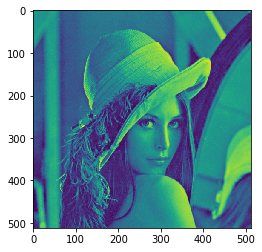

In [5]:
import cv2
import matplotlib.pyplot as plt
img_bgr = cv2.imread('lena512rgb.tiff', 0)
plt.imshow(img_bgr)

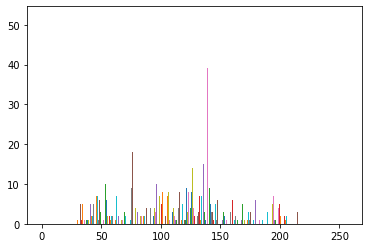

In [6]:
plt.hist(img_bgr,256,[0,256])
plt.show()

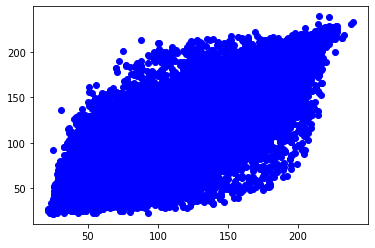

In [7]:
#Horizontal Correlation
x = []
y = []
for i in range(0,512):
    for j in range(0,511):
        x.append(img_bgr[i][j])
        y.append(img_bgr[i][j+1])
plt.plot(x,y,'bo')

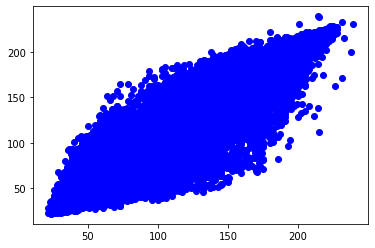

In [8]:
#Vertical correlation
vx = []
vy = []
for i in range(0,511):
    for j in range(0,512):
        vx.append(img_bgr[i][j])
        vy.append(img_bgr[i+1][j])
plt.plot(vx,vy,'bo')

In [9]:
key = KeyGen()

In [10]:
start_time = time.time()
encImg = ImgEncrypt(key, img_bgr)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))

--- 1.3200035095214844 seconds ---


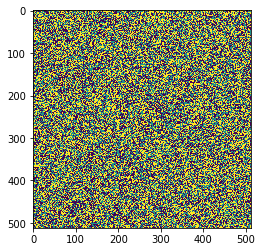

In [11]:
plt.imshow(encImg.astype(np.float))

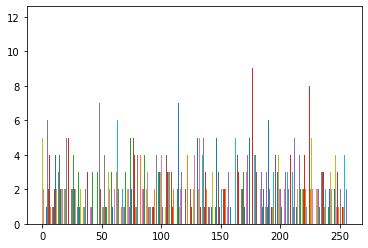

In [12]:
plt.hist(encImg%256,256,[0,256])
plt.show()

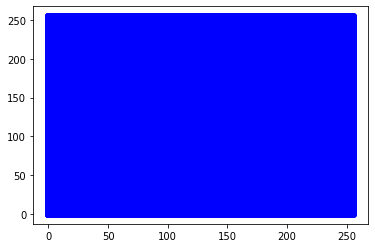

In [13]:
#Horizontal correlation 
x1 = []
y1 = []
for i in range(0,512):
    for j in range(0,511):
        x1.append(encImg[i][j]%256)
        y1.append(encImg[i][j+1]%256)
plt.plot(x1,y1,'bo')

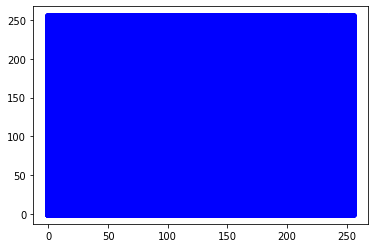

In [14]:
#Vertical correlation
v1 = []
v2 = []
for i in range(0,511):
    for j in range(0,512):
        v1.append(encImg[i][j]%256)
        v2.append(encImg[i+1][j]%256)
plt.plot(v1,v2,'bo')

In [15]:
start_time = time.time()
decImg = ImgDecrypt(key, encImg)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))

--- 2.127850294113159 seconds ---


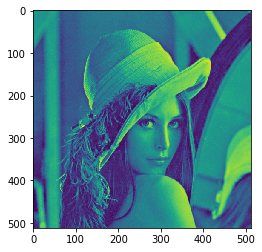

In [16]:
plt.imshow(decImg.astype(np.float))

In [17]:
#homoMult
k1=KeyGen()
def homomorphic_mult(key,e1,e2):
    p,q,a=key
    return (e1*e2)%p

encVal=homomorphic_mult(k1,Encrypt(k1,9),Encrypt(k1,5))
decAns=Decrypt(k1,encVal)
# print(encVal,decAns)

In [18]:
#homoAdd
def homomorphic_add(key,e1,e2):
    p,q,a=key
    return (e1+e2)%p
#     return (a*((w1+w2)*q+i1+i2))%p

encVal=homomorphic_add(k1,Encrypt(k1,9),Encrypt(k1,5))
decAns=Decrypt(k1,encVal)
print(encVal,decAns)

436717238545803763184748328261199997572445202 14


--- 0.4722254276275635 seconds ---


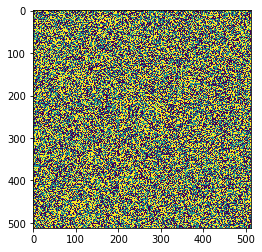

In [19]:
#homobright
def homomorphicBrightness(key,cipherimg,factor):
    shape = cipherimg.shape
    brightimg = cipherimg.flatten().tolist()
    factor = Encrypt(key, factor)
    brightimg = [homomorphic_add(key, factor, pix) for pix in brightimg]
    return np.asarray(brightimg).reshape(shape)

start_time = time.time()
heb=homomorphicBrightness(key,encImg,100)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(heb.astype(np.float))


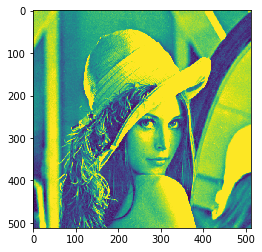

In [20]:
gray = img_bgr.copy()
gray = gray.astype('float32')

intensity_shift = 100
gray += intensity_shift

gray = np.clip(gray, 0, 255)

gray = gray.astype('uint8')
plt.imshow(gray)

--- 1.9545300006866455 seconds ---


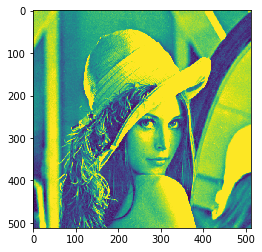

In [21]:
start_time = time.time()
hdb=ImgDecrypt(key,heb)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(hdb.astype(np.float))

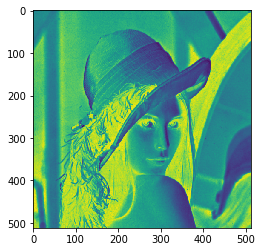

In [22]:
height, width = img_bgr.shape
neg_img = img_bgr.copy()

for i in range(0, height - 1):
    for j in range(0, width - 1):
        pixel = img_bgr[i, j]
        pixel = 255 - pixel
        neg_img[i, j] = pixel

plt.imshow(neg_img)

--- 0.5934727191925049 seconds ---


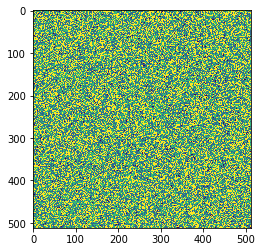

In [23]:
#homonef
def homomorphic_negation(key,encImg):
    shape = encImg.shape
    neg_encImg = encImg.flatten().tolist()
    maximum = Encrypt(key, 255)
    neg_encImg = [homomorphic_add(key, maximum, additiveInverse(pix, key[0])) for pix in neg_encImg]
    return np.asarray(neg_encImg).reshape(shape)

start_time = time.time()
neg_encImg = homomorphic_negation(key, encImg)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(neg_encImg.astype(np.float))

--- 2.0235869884490967 seconds ---


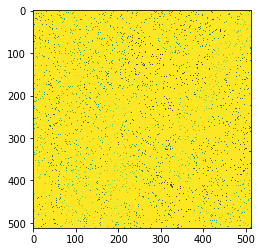

In [24]:
start_time = time.time()
neg_decImg = ImgDecrypt(key, neg_encImg)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(neg_decImg)

In [25]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [26]:
calculate_psnr(neg_img, neg_decImg)

6.834177329642087

In [27]:
def calculate_mse(img1,img2):
    return np.mean((img1 - img2)**2)

In [28]:
calculate_mse(neg_img, neg_decImg)

13479.153774261475

In [29]:
import math
import numpy as np
import cv2

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [30]:
calculate_ssim(neg_img, neg_decImg)

0.14327908193714647

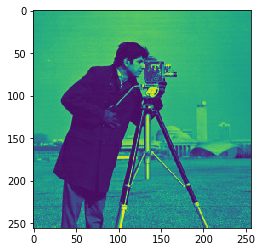

In [93]:
img_bgr1 = cv2.imread('cameraman.jpeg', 0)
plt.imshow(img_bgr1)

In [94]:
start_time = time.time()
encImg1 = ImgEncrypt(key, img_bgr1)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))

--- 0.11472558975219727 seconds ---


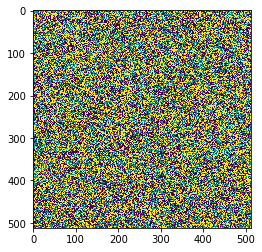

In [95]:
plt.imshow(encImg.astype(np.float))

--- 0.0359036922454834 seconds ---


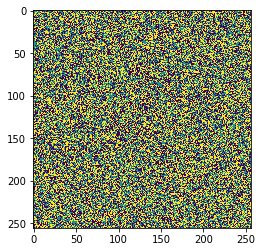

In [96]:
#homobright
def homomorphicBrightness(key,cipherimg,factor):
    shape = cipherimg.shape
    brightimg = cipherimg.flatten().tolist()
    factor = Encrypt(key, factor)
    brightimg = [homomorphic_add(key, factor, pix) for pix in brightimg]
    return np.asarray(brightimg).reshape(shape)

start_time = time.time()
heb1=homomorphicBrightness(key,encImg1,100)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(heb1.astype(np.float))

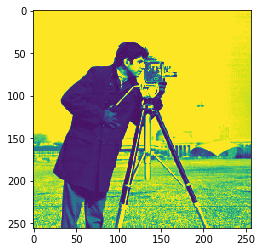

In [110]:
gray1 = img_bgr1.copy()
gray1 = gray1.astype('float32')

intensity_shift = 100
gray1 += intensity_shift

gray1 = np.clip(gray1, 0, 255)

gray1 = gray1.astype('uint8')
plt.imshow(gray1)

--- 0.1795198917388916 seconds ---


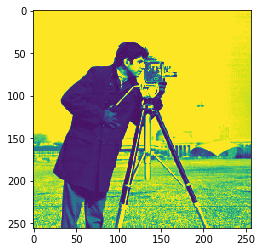

In [97]:
start_time = time.time()
hdb1=ImgDecrypt(key,heb1)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(hdb1.astype(np.float))

--- 0.054846763610839844 seconds ---


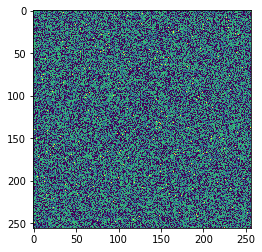

In [98]:
#homonef
def homomorphic_negation(key,encImg):
    shape = encImg.shape
    neg_encImg = encImg.flatten().tolist()
    maximum = Encrypt(key, 255)
    neg_encImg = [homomorphic_add(key, maximum, additiveInverse(pix, key[0])) for pix in neg_encImg]
    return np.asarray(neg_encImg).reshape(shape)

start_time = time.time()
neg_encImg1 = homomorphic_negation(key, encImg1)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(neg_encImg1.astype(np.float))

--- 0.17787861824035645 seconds ---


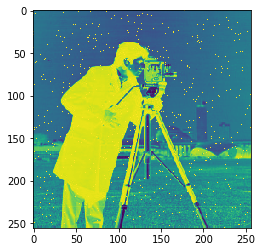

In [100]:
start_time = time.time()
neg_decImg1 = ImgDecrypt(key, neg_encImg1)
end_time=time.time()
print("--- %s seconds ---" % (end_time - start_time))
plt.imshow(neg_decImg1)

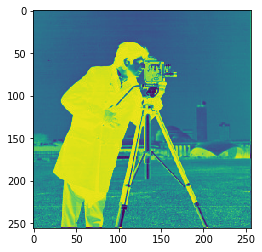

In [101]:
height, width = img_bgr1.shape
neg_img1 = img_bgr1.copy()

for i in range(0, height - 1):
    for j in range(0, width - 1):
        pixel = img_bgr1[i, j]
        pixel = 255 - pixel
        neg_img1[i, j] = pixel

plt.imshow(neg_img1)

In [102]:
calculate_psnr(neg_img1, neg_decImg1)

24.04250492748814

In [103]:
calculate_mse(neg_img1, neg_decImg1)

256.34796142578125

In [106]:
calculate_ssim(neg_img1, neg_decImg1)

0.7794998325781126

In [111]:
print(calculate_psnr(gray1, hdb1))
print(calculate_mse(gray1, hdb1))
print(calculate_ssim(gray1, hdb1))

inf
0.0
1.0
